# TinyML with gyro & accelerometer data

This Jupyter Notebook is part of the [Interactive Systems course at KISD in WS 22/23](https://github.com/KISDinteractive/embedded_ai_22w). It is based on a [Github repo by "billiyz"](https://github.com/billiyz/tinyml-on-the-edge) but optimized to be used on an M5StickC-Plus (ESP32) MCU programmed with the Arduino IDE and the [EloquentTinyML Library for Arduino by Simone Salerno](https://eloquentarduino.com/eloquent-tinyml/).

## Collect data
Before we can *train the model with this Notebook* we need to collect and classify data. 
1. Use the "record_imu_data.ino" Arduino sketch to do so and collect at least 20 gesture samples for each gesture type.
2. Upload the data into a subfolder of "datasets" in csv format. Pay attention to the format: 
    - "aX,aY,aZ,gX,gY,gZ" header + line break
    - 100x lines with six IMU samples (0.0 - 1.0 floats) separated by commas + line break
    - an additional line break after 100 readings, marking the end of one gesture
3. Add the names of your two categories to the "GESTURES" variable in the "Settings" code cell just below. The csv files have to be named respectively
4. Enter the number of gesture samples recorded with the Arduino code (e.g. 80) in "SAMPLES_PER_GESTURE" in the "Settings" code cell 

## Settings

In [57]:
# to be able to store multiple datasets we define a foldername in which the csv files are placed. This can be e.g. a time stamp
datasetName = "leftright"

# the list of gestures that data is available for
GESTURES = ["left", "right"]
NUM_GESTURES = len(GESTURES)

# the number of samples recorded per gesture. Has to be the same in the Arduino recording sketch!
SAMPLES_PER_GESTURE = 80

# percentage of the dataset that will be used for training, validation and testing
percent_training_data = 0.6
percent_validation_data = 0.2

## Load dependencies and check versions

In [58]:
# load some modules needed for the training
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras import layers
from tqdm.keras import TqdmCallback #for displaying the training as a progress bar

In [59]:
# Print versions. We need to see Python 3.7 in Jupyter AND the Shell (!python --version) as well as tensorflow 2.1.1 to work with the Eloquent Arduino library
from platform import python_version
print('Jupyter Python ' + python_version())
!python --version
print('Numpy ' + np.__version__)
print('Pandas ' + pd.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)
print("")
print("PLEASE DOUBLE CHECK if python is on 3.7 and tensorflow on 2.1.1")

Jupyter Python 3.7.12
Python 3.7.12
Numpy 1.21.6
Pandas 1.3.5
TensorFlow 2.1.1
Keras 2.3.0-tf

PLEASE DOUBLE CHECK if python is on 3.7 and tensorflow on 2.1.1


# Graph and inspect nature of data

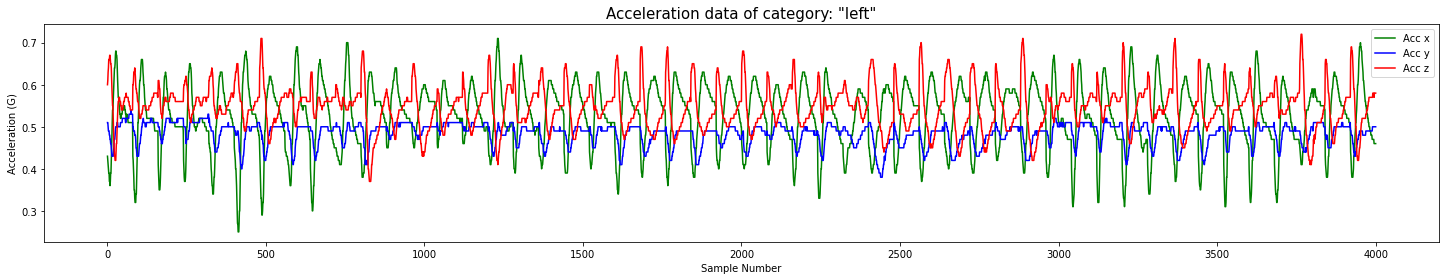

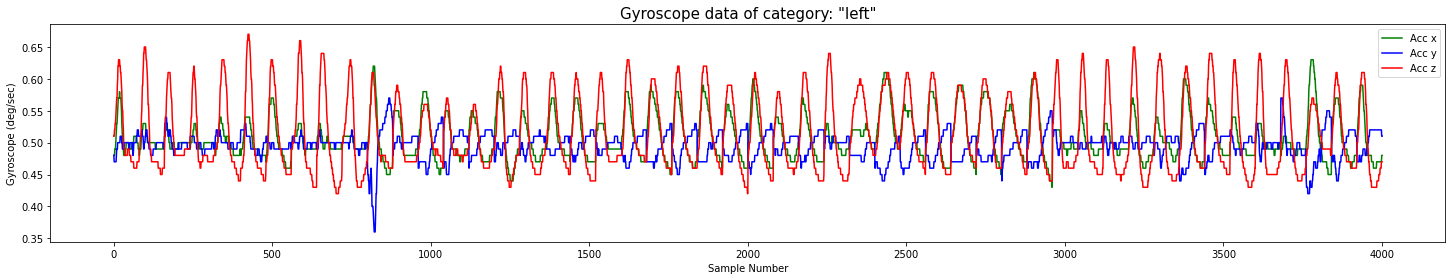

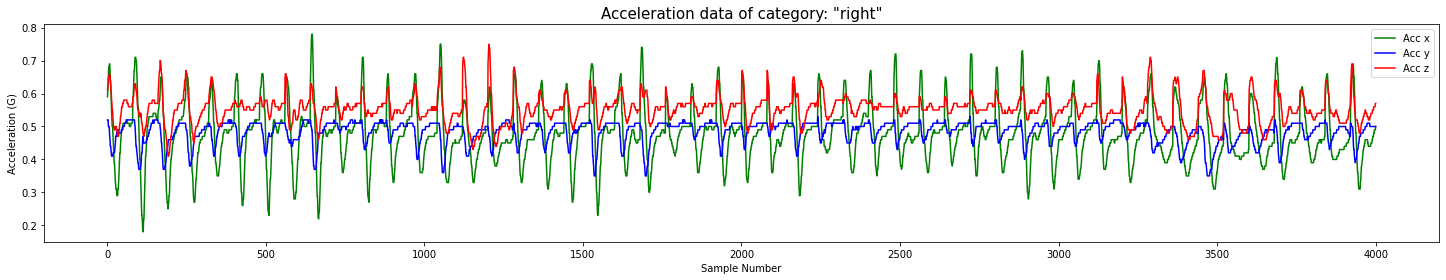

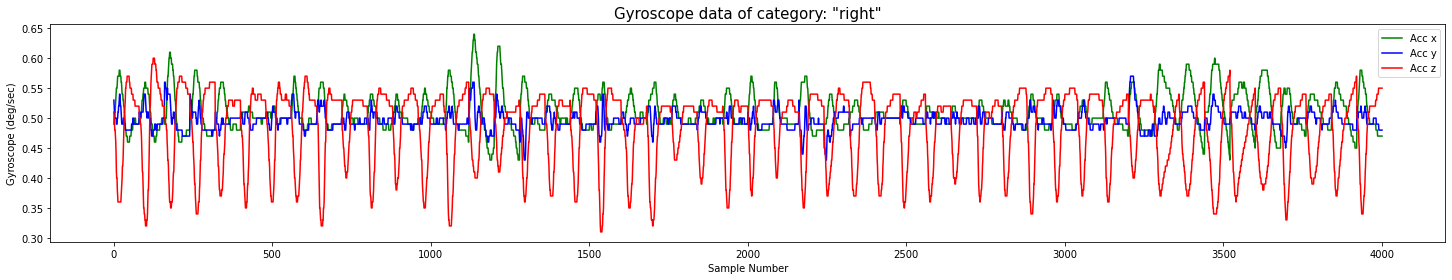

In [60]:
# print out gyro und accelerometer data separately for both categories to visualize the input data
for gesture_index in range(NUM_GESTURES):
    plt.rcParams["figure.figsize"] = (25,4)
    gestName = GESTURES[gesture_index]
    filename = "datasets/" + datasetName + "/" + gestName +".csv"
    df = pd.read_csv(filename)
    index = range(1, len(df['aX']) + 1)
    plt.plot(index, df['aX'], 'g', label='Acc x', linestyle='solid')
    plt.plot(index, df['aY'], 'b', label='Acc y', linestyle='solid')
    plt.plot(index, df['aZ'], 'r', label='Acc z', linestyle='solid')
    plt.title("Acceleration data of category: \"" + gestName +"\"", fontsize=15)
    plt.xlabel("Sample Number")
    plt.ylabel("Acceleration (G)")
    plt.legend()
    plt.show()
    plt.plot(index, df['gX'], 'g', label='Acc x', linestyle='solid')
    plt.plot(index, df['gY'], 'b', label='Acc y', linestyle='solid')
    plt.plot(index, df['gZ'], 'r', label='Acc z', linestyle='solid')
    plt.title("Gyroscope data of category: \"" + gestName +"\"", fontsize=15)
    plt.xlabel("Sample Number")
    plt.ylabel("Gyroscope (deg/sec)")
    plt.legend()
    plt.show()

## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [61]:
# Set a fixed random seed value, for reproducibility
SEED = 456456
np.random.seed(SEED)
tf.random.set_seed(SEED)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []
num_recordings_all = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")
    
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    filename = "datasets/" + datasetName + "/" + gesture +".csv"
    df = pd.read_csv(filename)
  
    # calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
    for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j
            tensor += [
                df['aX'][index],
                df['aY'][index],
                df['aZ'][index],
                df['gX'][index],
                df['gY'][index],
                df['gZ'][index]
            ]
        
        inputs.append(tensor)
        outputs.append(output)
        num_recordings_all.append(num_recordings)


# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

# print out some information
print("")
print("Data set parsing and preparation complete.")
print("")
if all(x==num_recordings_all[0] for x in num_recordings_all):
   print("The number of samples is identical in all classes of gestures: ", num_recordings_all[0] )
print("")
print("The whole input dataset has this shape:" , inputs.shape)
print("The whole output dataset has this shape:" , outputs.shape)

Processing index 0 for gesture 'left'.
	There are 50 recordings of the left gesture.
Processing index 1 for gesture 'right'.
	There are 50 recordings of the right gesture.

Data set parsing and preparation complete.

The number of samples is identical in all classes of gestures:  50

The whole input dataset has this shape: (100, 480)
The whole output dataset has this shape: (100, 2)


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data. If not defined in another way in the "Settings" section we use 60% for training, 20% for validation, and 20% for testing. 

In [62]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)
# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings into three sets: training, testing and validation
TRAIN_SPLIT = int(percent_training_data * num_inputs)
TEST_SPLIT = int(percent_validation_data * num_inputs + TRAIN_SPLIT)
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print("")
print("The training input dataset has this shape:" , inputs_train.shape)
print("The training outout dataset has this shape:" , outputs_train.shape)

Data set randomization and splitting complete.

The training input dataset has this shape: (60, 480)
The training outout dataset has this shape: (60, 2)


## Build & Train the Model

In [99]:
tf.random.set_seed(SEED)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4, activation='relu')) 
model.add(tf.keras.layers.Dense(4, activation='relu')) 
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, 
                    epochs=1000, 
                    batch_size=20, 
                    verbose=0, 
                    validation_data=(inputs_validate, outputs_validate), 
                    callbacks=[TqdmCallback(verbose=0)])
#history = model.fit(inputs_train, outputs_train, epochs=80, batch_size=2, verbose=0, validation_data=(inputs_validate, outputs_validate), callbacks=[TqdmCallback(verbose=0)])

100%|██████████| 1000/1000 [00:11<00:00, 84.04epoch/s, loss=8.52e-6, mae=0.00212, val_loss=1.37e-5, val_mae=0.00304]


## Validate

Show learning curve and a visualization how the model performs on the training / validation data

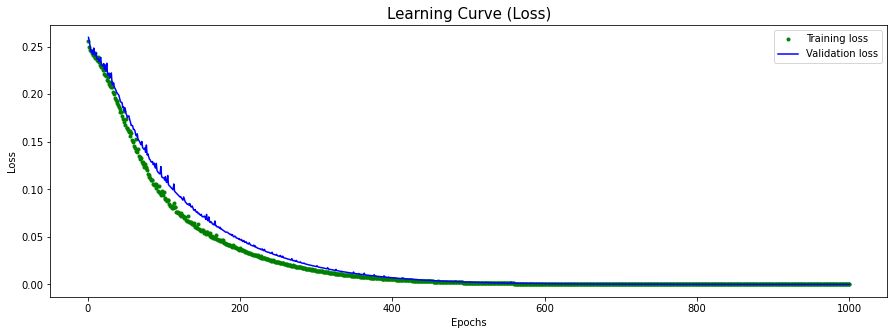

In [100]:
plt.rcParams["figure.figsize"] = (15,5)
# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Learning Curve (Loss)', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

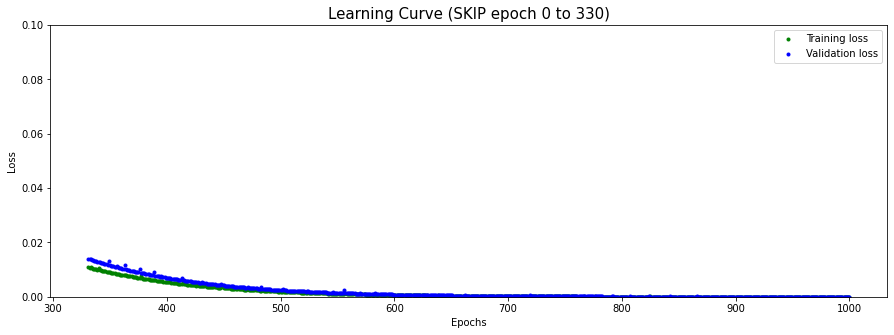

In [101]:
# define size
plt.rcParams["figure.figsize"] = (15,5)
# graph the loss again skipping the first quarter of the epochs
SKIP = int(len(epochs)*0.33)
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Learning Curve (SKIP epoch 0 to ' + str(SKIP) + ')', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.1)
plt.legend()
plt.show()

### Graph the loss

Graph the loss to see when the model stops improving.

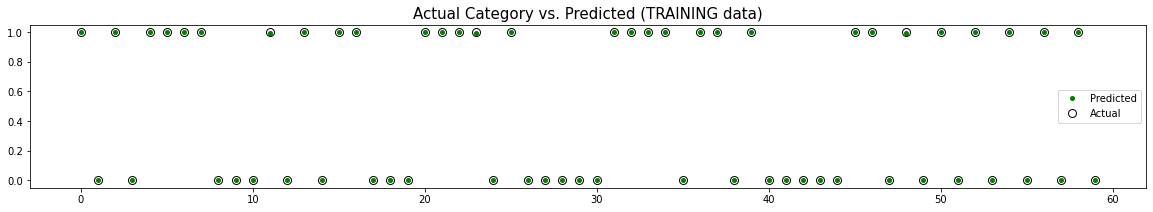

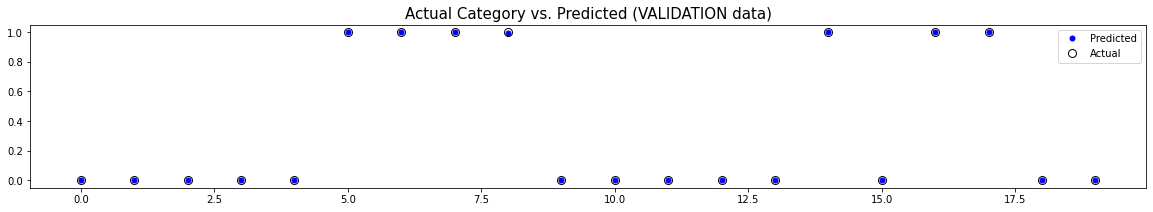

In [102]:
# use the model to predict the test inputs
predictions_train = model.predict(inputs_train)
predictions_validate = model.predict(inputs_validate)

# Plot the predictions along with to the test data
plt.rcParams["figure.figsize"] = (20,3)
plt.clf()
plt.title('Actual Category vs. Predicted (TRAINING data)', fontsize=15)
plt.plot(range(int(num_recordings_all[0]*percent_training_data*2)),[ x[0] for x in predictions_train], 'o', color="g", markersize=4,  label='Predicted')
plt.plot(range(int(num_recordings_all[0]*percent_training_data*2)),[ x[0] for x in outputs_train], 'o', color="black", markersize=8, mfc='none', label='Actual')
plt.legend()
plt.show()
plt.clf()
plt.title('Actual Category vs. Predicted (VALIDATION data)', fontsize=15)
plt.plot(range(int(num_recordings_all[0]*percent_validation_data*2)),[ x[0] for x in predictions_validate], 'o', color="b", markersize=5,  label='Predicted')
plt.plot(range(int(num_recordings_all[0]*percent_validation_data*2)),[ x[0] for x in outputs_validate], 'o', color="black", markersize=8, mfc='none', label='Actual')
plt.legend()
plt.show()

### Run with Test Data
If everything looks fine, we can test how the model performs on the till here unknown "testing" dataset:

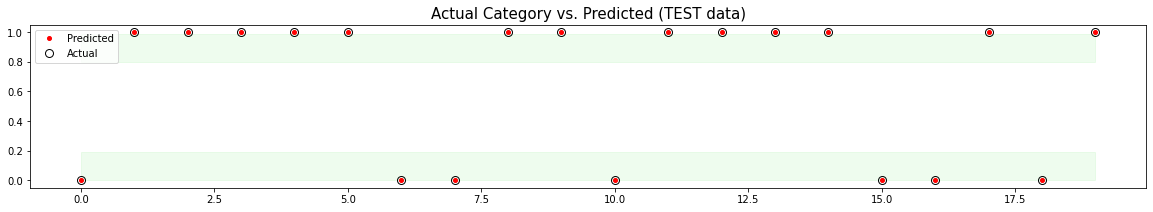

In [103]:
# use the model to predict the test inputs
predictions_test = model.predict(inputs_test)

# Plot the predictions along with to the test data
plt.rcParams["figure.figsize"] = (20,3)
plt.clf()
plt.title('Actual Category vs. Predicted (TEST data)', fontsize=15)
lower = np.arange(0,0.2,0.01)
upper = np.arange(0.8,1,0.01)
plt.fill_betweenx(lower,0,num_recordings_all[0]*percent_validation_data*2-1 , color='lightgreen', alpha=.15)
plt.fill_betweenx(upper,0,num_recordings_all[0]*percent_validation_data*2-1 , color='lightgreen', alpha=.15)
plt.plot(range(int(num_recordings_all[0]*percent_validation_data*2)),[ x[0] for x in predictions_test], 'o', color="r", markersize=4,  label='Predicted')
plt.plot(range(int(num_recordings_all[0]*percent_validation_data*2)),[ x[0] for x in outputs_test], 'o', color="black", markersize=8, mfc='none', label='Actual')
plt.legend()
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [104]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 9428 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [89]:
!echo "//this model was created with the TFGyroData Jupyter Notebook. Just place it in the same folder as the .ino file" > model.h
!echo "const unsigned char model[] = {" >> model.h
!cat model.tflite | xxd -i              >> model.h
!echo "};"                              >> model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 58,287 bytes.
